In [49]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dateutil.relativedelta import relativedelta


In [15]:
tickersymbol = 'MSFT'

In [16]:
tickerdata = yf.Ticker(tickersymbol)

In [17]:
msdata = tickerdata.history(period='max',interval='1mo')
msdata = pd.DataFrame(msdata)
msdata.index = msdata.index.date
msdata

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-04-01,0.058758,0.075051,0.057156,0.068908,547142400,0.00,0.0
1986-05-01,0.068908,0.075852,0.066237,0.074784,333446400,0.00,0.0
1986-06-01,0.074784,0.074784,0.063032,0.065703,293788800,0.00,0.0
1986-07-01,0.065703,0.067305,0.055554,0.060895,460800000,0.00,0.0
1986-08-01,0.060895,0.065703,0.058224,0.060895,266256000,0.00,0.0
...,...,...,...,...,...,...,...
2024-08-01,419.193857,425.838540,384.117395,415.557709,451919000,0.75,0.0
2024-09-01,417.075166,440.967345,399.999330,429.440399,376921200,0.00,0.0
2024-10-01,427.594128,437.624039,405.488351,405.538269,440745500,0.00,0.0
2024-11-01,408.192959,428.472344,404.759828,422.614075,442321200,0.83,0.0


In [18]:
returns = 100 * msdata.Close.pct_change().dropna()

Text(0.5, 1.0, 'DIS Returns')

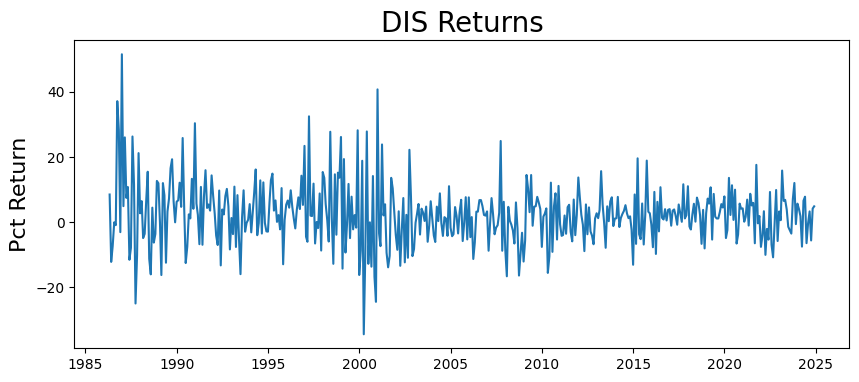

In [19]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('DIS Returns', fontsize=20)

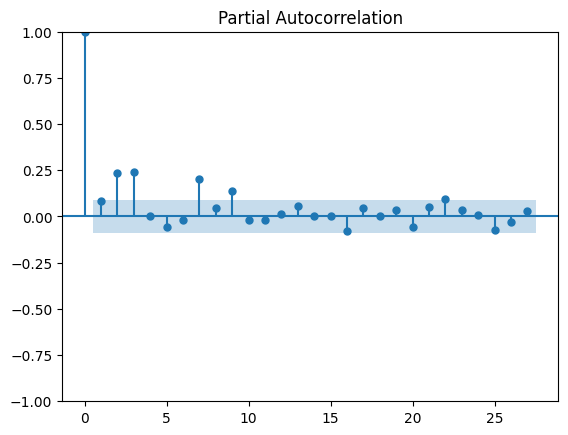

In [20]:
plot_pacf(returns**2)
plt.show()

In [39]:
model = arch_model(returns, p=3, q=0)
model_fit = model.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1688.2981035639386
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1692.6763881324719
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1705.5183465503405
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1678.742022595555
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1660.1417948172702
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1659.7925834162238
Iteration:      7,   Func. Count:     49,   Neg. LLF: 1667.8920929490237
Iteration:      8,   Func. Count:     56,   Neg. LLF: 1659.4043342703822
Iteration:      9,   Func. Count:     62,   Neg. LLF: 1659.3819846284296
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1659.354458548521
Iteration:     11,   Func. Count:     74,   Neg. LLF: 1659.2850709158065
Iteration:     12,   Func. Count:     80,   Neg. LLF: 1659.270877356701
Iteration:     13,   Func. Count:     86,   Neg. LLF: 1659.2700314001736
Iteration:     14,   Func. Count:     92,   Neg. LLF: 

In [40]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1659.27
Distribution:                  Normal   AIC:                           3328.54
Method:            Maximum Likelihood   BIC:                           3349.24
                                        No. Observations:                  464
Date:                Tue, Dec 10 2024   Df Residuals:                      463
Time:                        22:27:26   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             2.5065      0.389      6.440  1.195e-10 [  1.744,  3.269]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         41.5481      6.881      6.038  1.556e-09   [ 28.062, 55.034]
alpha[1]       0.1189  5.757e-02      2.066  3.885e-02 [6.089e-03,  0.232]
alpha[2]       0.1612  7.689e-02      2.096  3.605e-02 [1.049e-02,  0.312]
alpha[3]       0.2342  9.013e-02      2.599  9.362e-03 [5.756e-02,  0.411]
==========================================================================

Covariance estimator: robust
"""

In [ ]:
'''Performs a rolling forecast over the last 365 data points. For each step, it:

Uses all data up to the current point as the training set.
Fits an ARCH(1,1) model.
Forecasts the variance for the next time point and stores its square root (volatility).'''

rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [ ]:
#Converts the rolling volatility predictions into a pandas.Series with the same index as the last 365 data points of the returns series.
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])

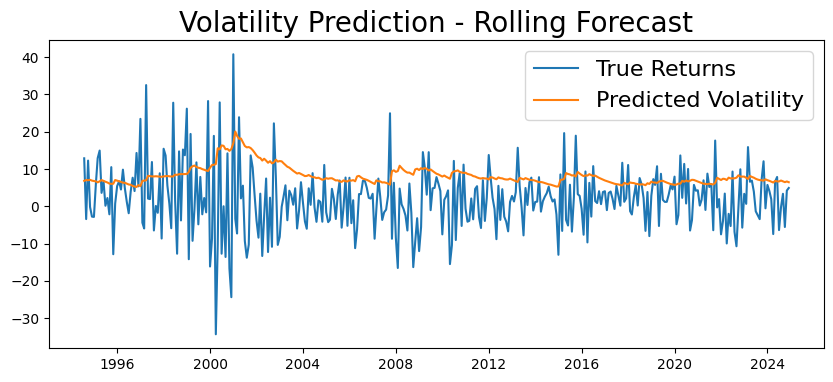

In [43]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

In [45]:
train = returns
model = arch_model(train, p=3, q=0)
model_fit = model.fit(disp='off')

In [ ]:
''' Forecasts the volatility for the next 7 months:

Generates the future dates.
Extracts and converts the forecasted variance into volatility (square root).
Stores it in a pandas.Series indexed by the future dates.'''

pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + relativedelta(months=i) for i in range(1, 8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Months')

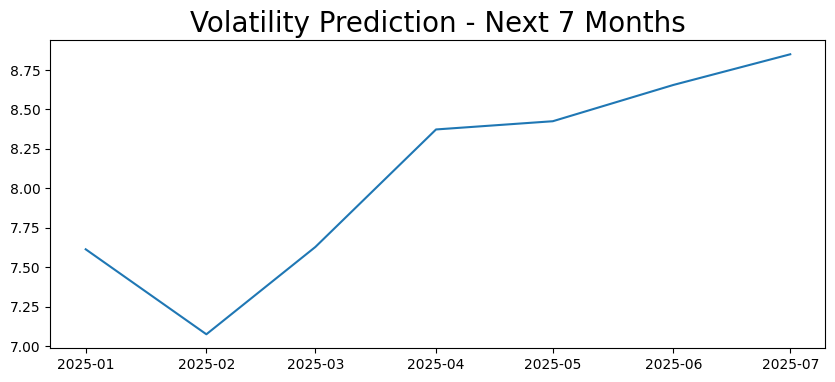

In [51]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Months', fontsize=20)